# Grass growth model evaluation

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import root_mean_squared_error
import geopandas as gpd
import numpy as np

In [2]:
# read time series of grass growth
grass_pbi = pd.read_csv(
    os.path.join(
        "data", "grass_growth", "PastureBaseIreland", "pasturebase_cleaned.csv"
    )
)
grass_gcni = pd.read_csv(
    os.path.join(
        "data", "grass_growth", "GrassCheckNI", "grasscheck_cleaned.csv"
    )
)
mera = pd.read_csv(
    os.path.join("data", "ModVege", "growth", "MERA_growth_week_pasture.csv")
)

In [3]:
mera = mera.set_index("time")
mera.index = pd.to_datetime(mera.index)
mera.rename(columns={"COUNTY": "county", "mean": "value"}, inplace=True)
mera["county"] = mera["county"].str.title()
mera = mera["2013":"2018"]

In [4]:
grass = pd.concat([grass_pbi, grass_gcni])
grass = pd.pivot_table(
    grass[["time", "county", "value"]],
    values="value",
    index=["time"],
    columns=["county"],
)
grass.index = pd.to_datetime(grass.index)
grass = grass["2013":"2018"]
grass = grass.melt(ignore_index=False)

In [5]:
# label measured and simulated data and merge
grass["data"] = "Measured"
mera["data"] = "Simulated"
data_all = pd.concat([grass, mera])

In [6]:
data_all["weekno"] = data_all.index.isocalendar().week
data_all["doy"] = data_all.index.dayofyear
data_all["year"] = data_all.index.year

In [7]:
data_all.dropna(inplace=True)

In [8]:
data_all.describe()[["value"]]

,value
count,17418.000000
mean,33.063244
std,29.451466
min,0.000000
25%,3.987281
50%,27.474330
75%,58.233070
max,150.610000


In [18]:
data_all.groupby(["county", "data"]).describe()[["value"]].head(32)

value                                             \
                     count       mean        std       min        25%   
county    data                                                          
Antrim    Measured    60.0  53.146667  23.916858  6.000000  35.700000   
          Simulated  313.0  27.449926  30.430542  0.000000   0.612428   
Armagh    Measured    60.0  46.488333  20.210830  9.400000  32.675000   
          Simulated  313.0  28.889398  31.875758  0.000000   0.815065   
Carlow    Measured   276.0  35.096232  22.153431  0.000000  13.952500   
          Simulated  313.0  23.131156  25.674030  0.000000   0.816741   
Cavan     Measured   286.0  35.550734  25.080062  0.000000   9.340000   
          Simulated  313.0  33.727190  36.852016  0.000000   0.951754   
Clare     Measured   288.0  37.401736  26.180254  1.020000  10.457500   
          Simulated  313.0  30.115779  29.846862  0.064351   1.775048   
Cork      Measured   312.0  37.146410  25.183239  0.000000  11.520000   
          Simulated  313.0  26.326234  27.587695  0.047661   1.450293   
Derry     Measured    60.0  53.130000  23.692088  3.800000  35.600000   
          Simulated  313.0  25.134020  28.389676  0.000000   0.535973   
Donegal   Measured   243.0  42.909506  26.943111  0.000000  16.830000   
          Simulated  313.0  30.033467  31.902723  0.000005   0.903567   
Down      Measured    60.0  53.496667  22.506970  7.700000  35.200000   
          Simulated  313.0  25.948456  28.308195  0.000000   0.851263   
Dublin    Measured   116.0  36.959828  24.125321  1.230000  20.790000   
          Simulated  313.0  23.833702  24.936316  0.000000   1.225865   
Fermanagh Measured    60.0  54.758333  21.310857  3.900000  41.650000   
          Simulated  313.0  34.079756  36.773641  0.000000   0.917749   
Galway    Measured   294.0  38.308248  25.104248  0.000000  11.945000   
          Simulated  313.0  32.254848  32.733873  0.007288   1.468384   
Kerry     Measured   283.0  38.764240  25.589697  0.000000  11.940000   
          Simulated  313.0  30.683545  29.723881  0.138996   2.116173   
Kildare   Measured   289.0  39.393616  25.709627  0.000000  14.130000   
          Simulated  313.0  25.866932  28.673971  0.000000   0.881257   
Kilkenny  Measured   307.0  35.683257  24.607123  0.000000  10.680000   
          Simulated  313.0  24.073635  26.638590  0.000000   0.916919   
Laois     Measured   303.0  35.497327  24.789543  0.520000  10.660000   
          Simulated  313.0  24.714538  27.657479  0.000000   0.703398   

                                                       
                           50%        75%         max  
county    data                                         
Antrim    Measured   53.500000  68.675000  110.400000  
          Simulated  12.344182  56.218554   99.525788  
Armagh    Measured   47.400000  57.175000   95.200000  
          Simulated  13.636103  58.997993  103.324583  
Carlow    Measured   36.950000  52.710000   83.540000  
          Simulated  11.259532  44.458806   89.519063  
Cavan     Measured   35.370000  57.630000  102.850000  
          Simulated  16.924116  67.513642  121.205320  
Clare     Measured   39.225000  61.765000  112.030000  
          Simulated  20.827829  55.771820  102.730366  
Cork      Measured   37.095000  60.527500   92.270000  
          Simulated  13.838315  49.039475   94.494867  
Derry     Measured   54.200000  68.325000  102.200000  
          Simulated   9.150708  50.862588   89.547505  
Donegal   Measured   48.610000  66.645000  112.190000  
          Simulated  15.409813  60.470394   99.186533  
Down      Measured   57.750000  72.625000   93.000000  
          Simulated  12.639432  52.678362   91.818640  
Dublin    Measured   33.560000  49.180000  150.610000  
          Simulated  14.618662  45.547186   85.445919  
Fermanagh Measured   57.250000  72.000000   87.200000  
          Simulated  16.775720  69.025276  119.611709  
Galway    Measured   41.645000  60.287500  101.570000  
         

In [21]:
data_all.groupby(["county", "data"]).describe()[["value"]].tail(32)

value                                             \
                     count       mean        std       min        25%   
county    data                                                          
Leitrim   Measured   140.0  50.293571  24.893390  0.000000  33.595000   
          Simulated  313.0  42.701566  44.370665  0.000000   1.492775   
Limerick  Measured   302.0  35.110579  24.551863  0.000000  10.150000   
          Simulated  313.0  29.123979  30.589711  0.000126   1.289842   
Longford  Measured   268.0  45.507090  28.584216  0.000000  18.725000   
          Simulated  313.0  33.401473  35.561598  0.000000   1.059137   
Louth     Measured   294.0  38.917908  26.150955  0.000000  12.090000   
          Simulated  313.0  23.594207  25.755579  0.000000   0.828635   
Mayo      Measured   269.0  38.885093  26.098307  0.000000  10.380000   
          Simulated  313.0  35.445430  35.664054  0.005365   1.500143   
Meath     Measured   298.0  37.262819  25.269233  0.000000  10.921250   
          Simulated  313.0  26.875765  29.767457  0.000000   0.851106   
Monaghan  Measured   270.0  39.209259  26.444674  1.360000  10.070000   
          Simulated  313.0  30.931272  34.343693  0.000000   0.792958   
Offaly    Measured   279.0  37.777384  23.841469  0.360000  15.160000   
          Simulated  313.0  25.444796  27.698376  0.000000   0.823603   
Roscommon Measured   221.0  38.836154  24.385972  0.000000  15.900000   
          Simulated  313.0  34.033309  36.098642  0.000000   1.082128   
Sligo     Measured   261.0  37.193295  23.377516  1.390000  13.330000   
          Simulated  313.0  38.249012  38.861422  0.000000   1.440413   
Tipperary Measured   310.0  36.349984  25.380885  1.845000   9.847500   
          Simulated  313.0  27.621946  29.548627  0.000000   1.087953   
Tyrone    Measured    60.0  57.286667  21.546563  2.800000  44.825000   
          Simulated  313.0  28.568031  32.021490  0.000000   0.608669   
Waterford Measured   310.0  34.826048  24.561738  0.000000   9.625000   
          Simulated  313.0  23.738835  25.528583  0.002250   1.196338   
Westmeath Measured   265.0  38.540415  23.978729  0.000000  14.220000   
          Simulated  313.0  29.763322  32.419060  0.000000   0.989116   
Wexford   Measured   293.0  37.493038  24.207332  0.000000  13.470000   
          Simulated  313.0  22.001784  23.783920  0.001681   1.028372   
Wicklow   Measured   265.0  39.090604  25.186330  0.960000  13.040000   
          Simulated  313.0  24.459046  27.131236  0.000000   0.708889   

                                                       
                           50%        75%         max  
county    data                                         
Leitrim   Measured   53.850000  68.670000  124.160000  
          Simulated  25.148943  82.061523  143.762684  
Limerick  Measured   36.300000  57.670000   91.000000  
          Simulated  17.296220  54.084892  106.359199  
Longford  Measured   51.105000  68.325000  124.310000  
          Simulated  17.351267  65.290133  116.953785  
Louth     Measured   39.140000  62.400000  120.800000  
          Simulated  11.328886  48.969879   83.501688  
Mayo      Measured   41.630000  60.150000   97.120000  
          Simulated  23.502917  68.985263  115.324882  
Meath     Measured   37.720000  59.365000   90.690000  
          Simulated  12.583754  53.621999   99.033932  
Monaghan  Measured   44.620000  62.787500   92.120000  
          Simulated  13.132411  62.683278  110.851762  
Offaly    Measured   40.240000  57.185000   84.530000  
          Simulated  12.114419  50.824128   91.728314  
Roscommon Measured   41.440000  57.420000  107.070000  
          Simulated  18.126018  63.565175  120.435219  
Sligo     Measured   40.420000  56.040000   85.030000  
          Simulated  22.901354  72.804196  122.056033  
Tipperary Measured   35.920000  60.512500   95.470000  
          Simulated  15.074609  52.277434   99.500000  
Tyrone    Measured   57.150000  71.275000   90.900000  
         

## Comparison

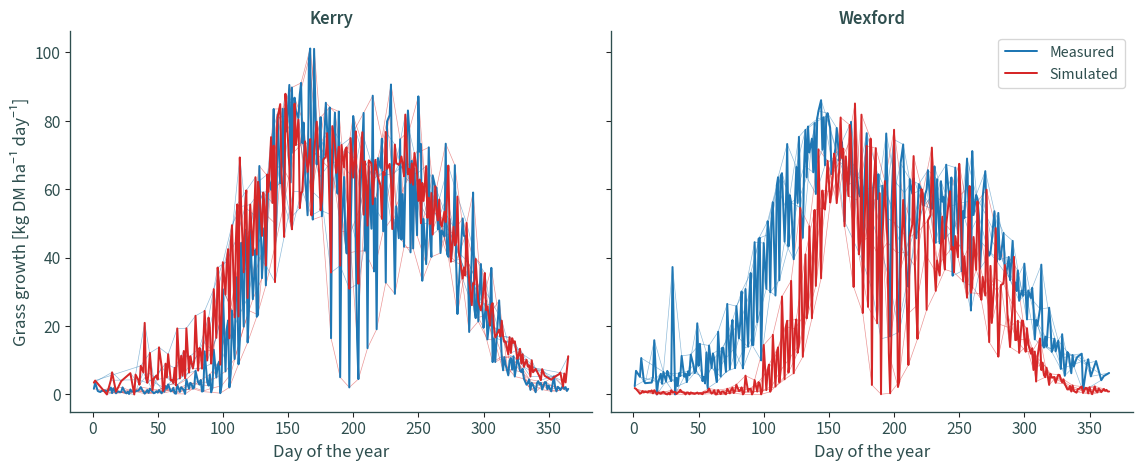

In [11]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
for n, (c, l) in enumerate(zip(["Kerry", "Wexford"], [False, True])):
    for year in list(set(data_all["year"])):
        sns.lineplot(data=data_all[(data_all["county"] == c) & (data_all["year"] == year)].reset_index(), x="doy", y="value", hue="data", errorbar=("pi", 100), ax=ax[n], legend=False, palette=sns.color_palette(["tab:blue", "tab:red"]), lw=0.5, alpha=.5)
    sns.lineplot(data=data_all[data_all["county"] == c].drop(columns=["county"]).groupby(["doy", "data"]).mean().sort_values(by=["doy"]), x="doy", y="value", hue="data", errorbar=("pi", 100), ax=ax[n], legend=l, palette=sns.color_palette(["tab:blue", "tab:red"]))
    ax[n].set_title(c)
    ax[n].set_xlabel("Day of the year")
    ax[n].set_ylabel("Grass growth [kg DM ha⁻¹ day⁻¹]")
plt.legend(title=None, fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

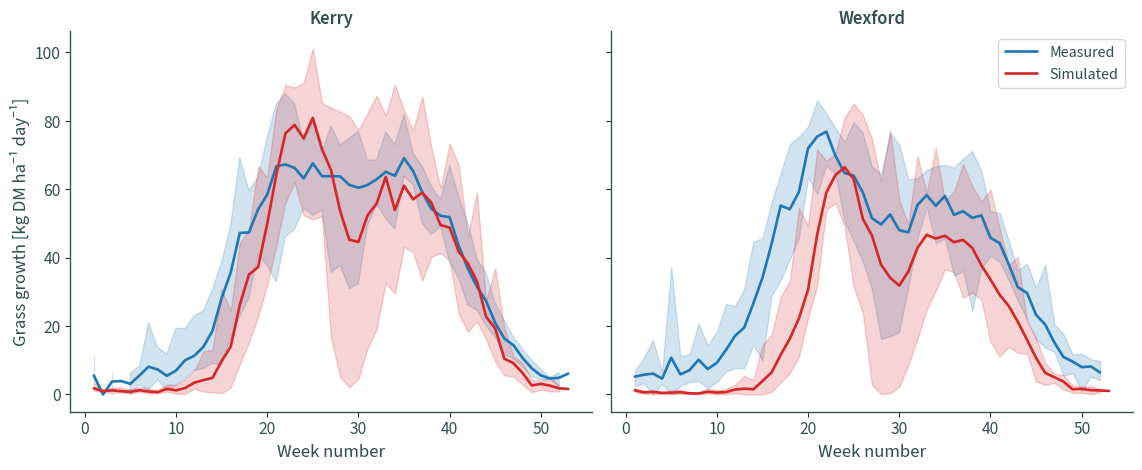

In [12]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 5))
for n, (c, l) in enumerate(zip(["Kerry", "Wexford"], [False, True])):
    sns.lineplot(data=data_all[data_all["county"] == c].reset_index(), x="weekno", y="value", hue="data", errorbar=("pi", 100), ax=ax[n], legend=l, palette=sns.color_palette(["tab:blue", "tab:red"]), lw=2)
    ax[n].set_title(c)
    ax[n].set_xlabel("Week number")
    ax[n].set_ylabel("Grass growth [kg DM ha⁻¹ day⁻¹]")
plt.legend(title=None, fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

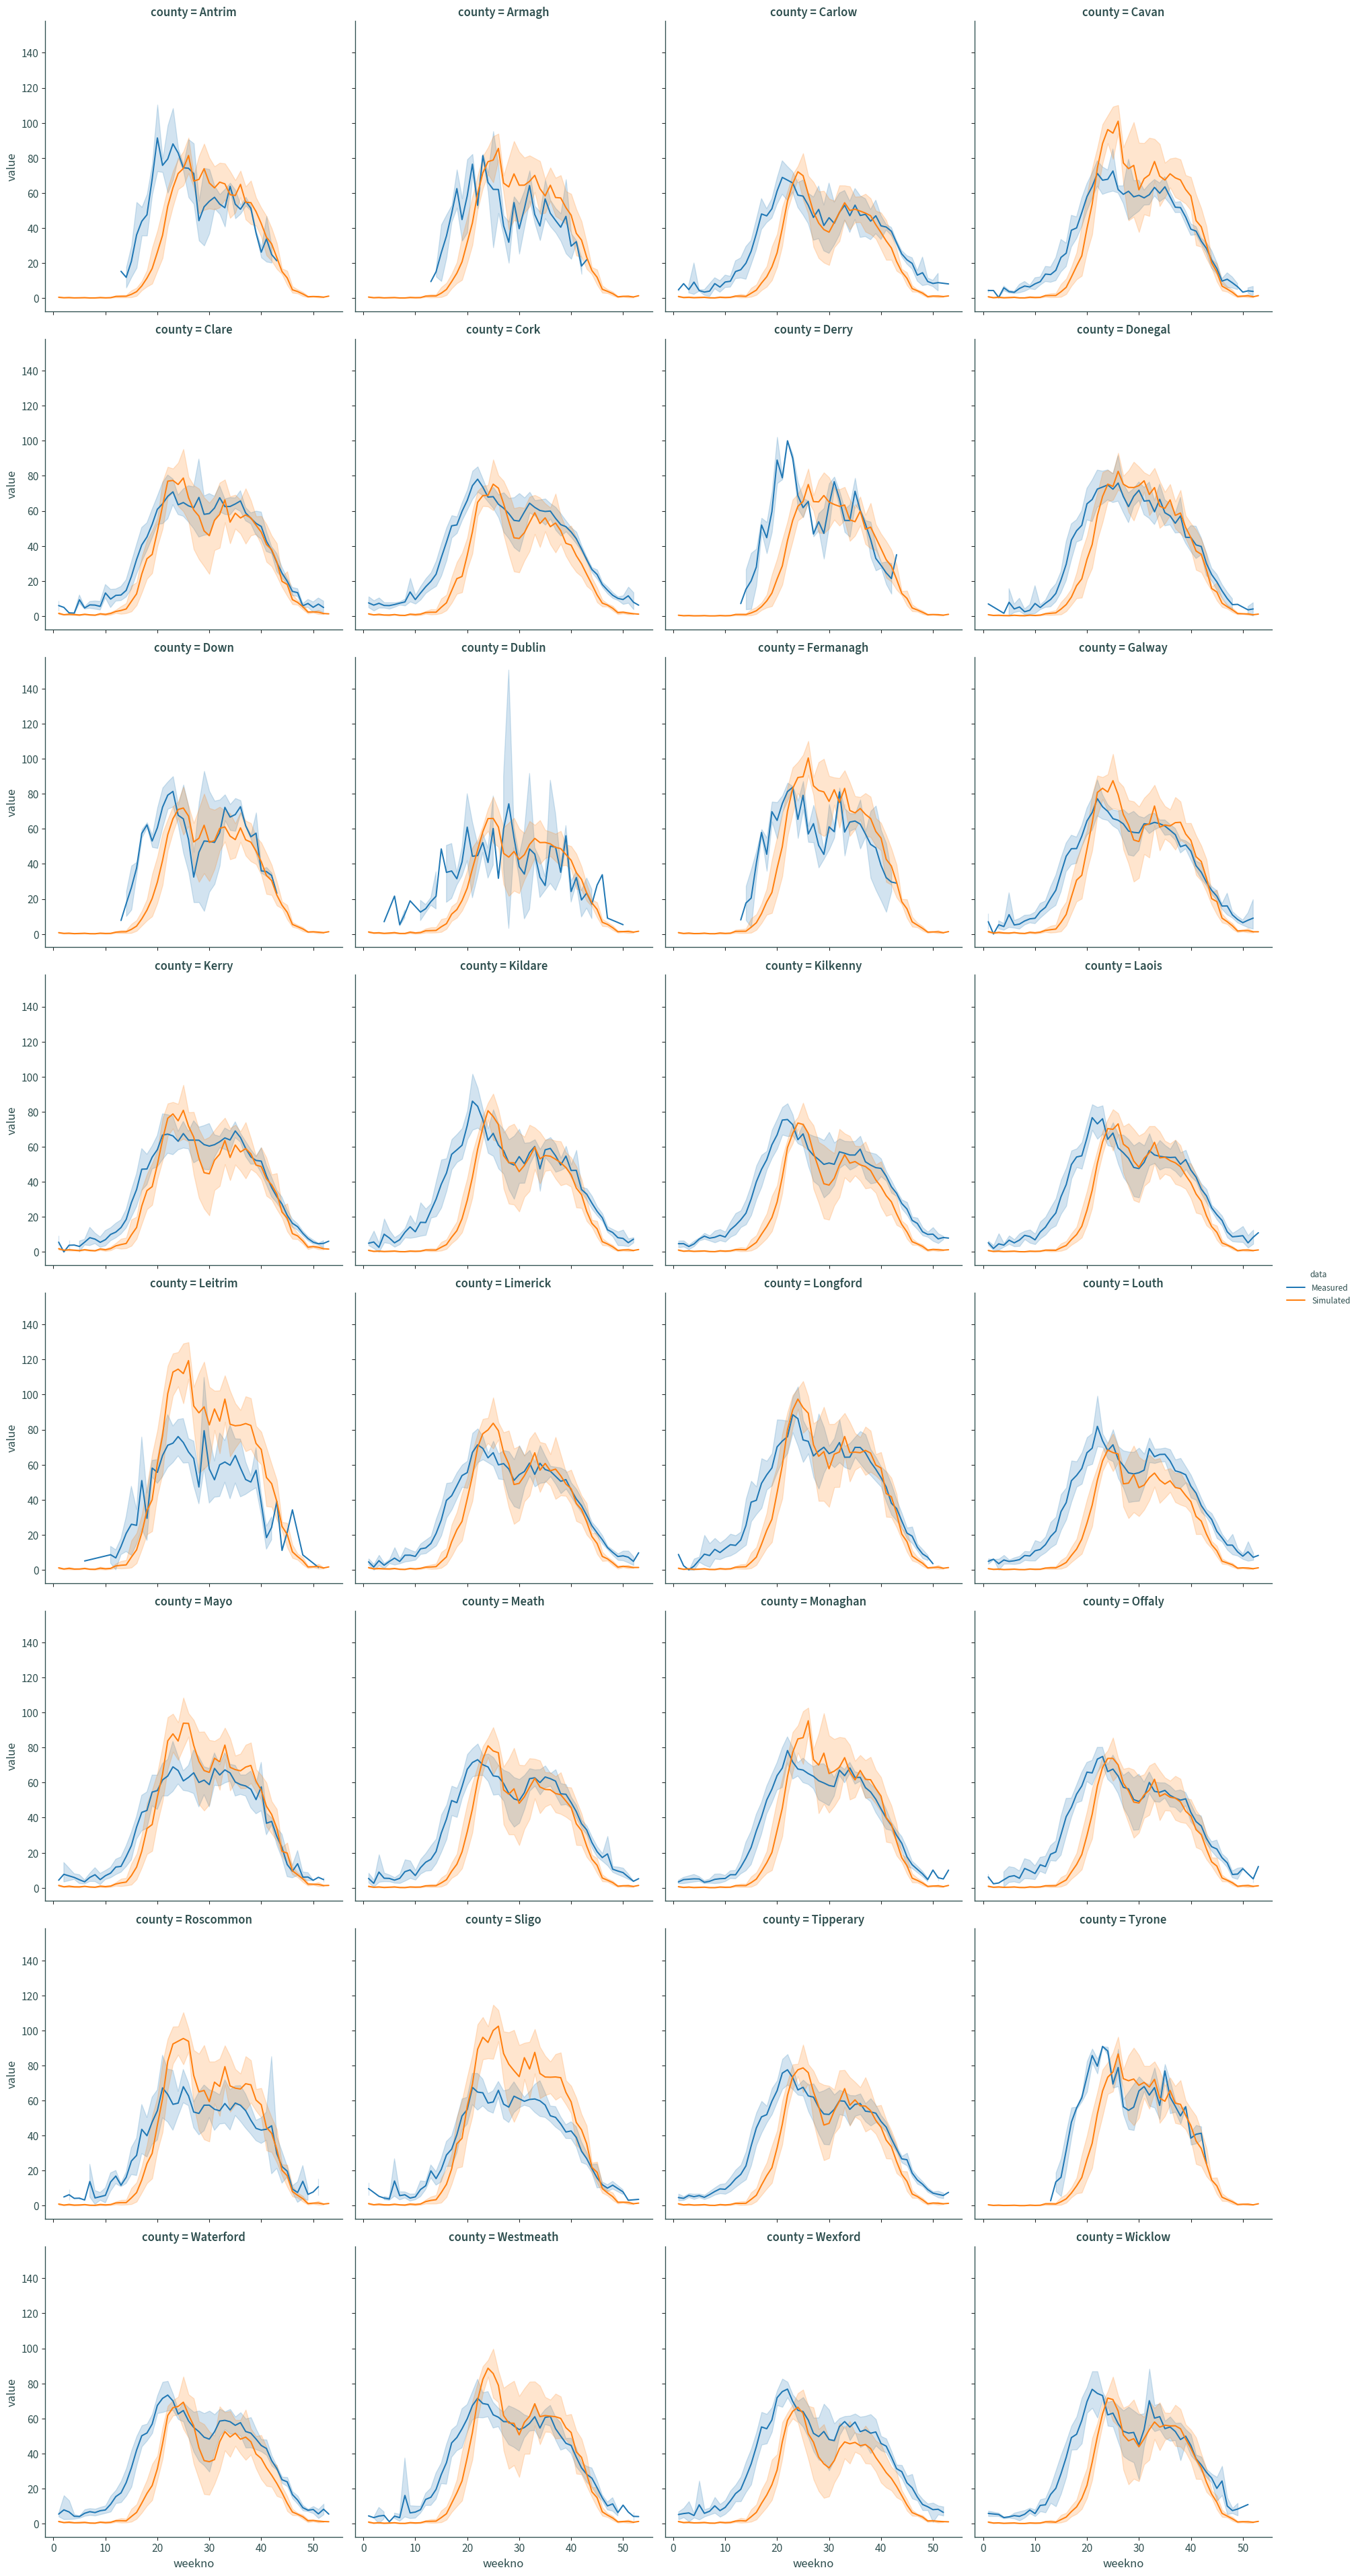

In [13]:
sns.relplot(data=data_all.reset_index(), x="weekno", y="value", hue="data", col="county", col_wrap=4, kind="line")
plt.show()

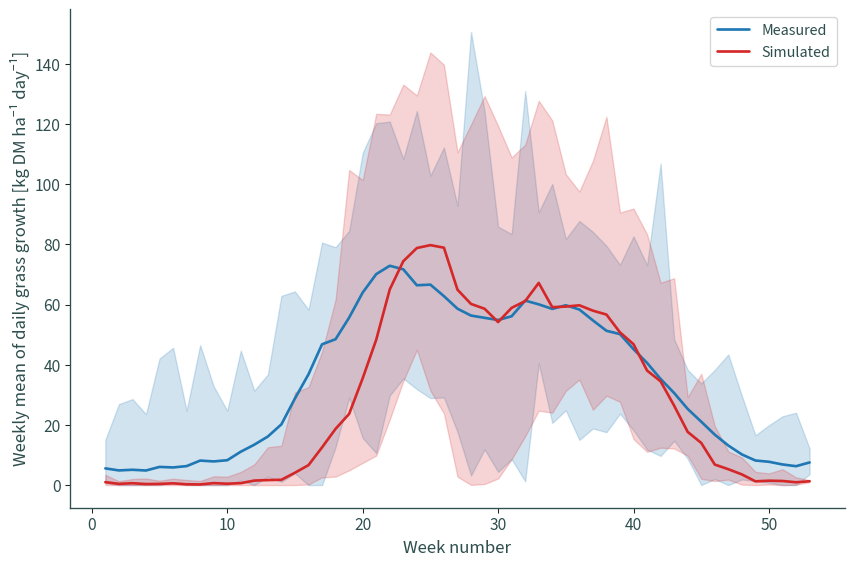

In [39]:
plt.figure(figsize=(9, 6))
ax = sns.lineplot(data=data_all.reset_index(), x="weekno", y="value", hue="data", errorbar=("pi", 100), palette=sns.color_palette(["tab:blue", "tab:red"]), lw=2)
ax.set_xlabel("Week number")
ax.set_ylabel("Weekly mean of daily grass growth [kg DM ha⁻¹ day⁻¹]")
plt.title(None)
plt.legend(title=None, fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

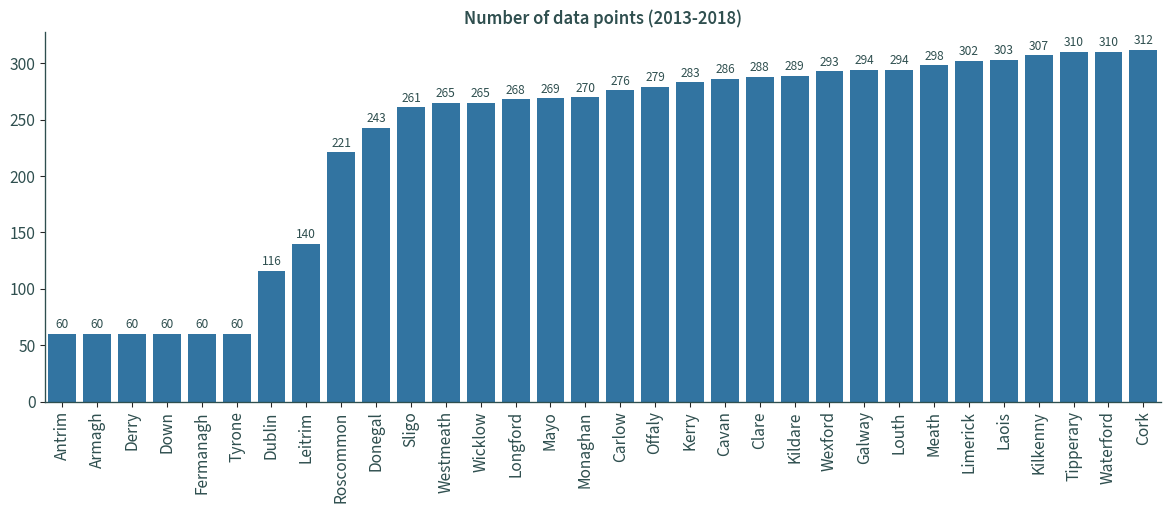

In [14]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=grass.dropna().groupby("county").count().sort_values(["value"]).reset_index(), x="county", y="value")
ax.bar_label(ax.containers[0], padding=2)
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel(None)
plt.title("Number of data points (2013-2018)")
sns.despine()
plt.show()

In [46]:
# drop counties with < 200 points
data_all_200 = data_all.copy()
for c in ["Antrim", "Armagh", "Derry", "Down", "Fermanagh", "Tyrone", "Dublin", "Leitrim"]:
# for c in ["Dublin", "Leitrim"]:
    data_all_200 = data_all_200[data_all_200["county"] != c]

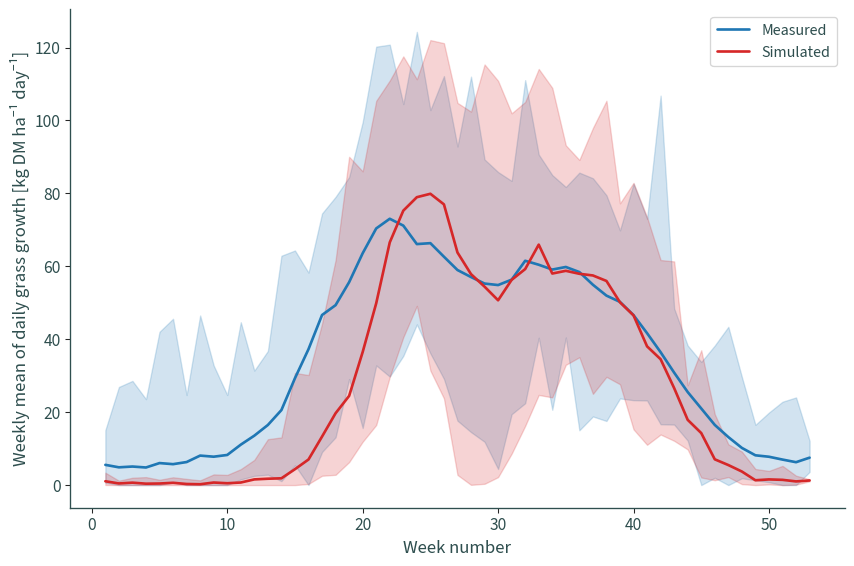

In [48]:
plt.figure(figsize=(9, 6))
ax = sns.lineplot(data=data_all_200.reset_index(), x="weekno", y="value", hue="data", errorbar=("pi", 100), palette=sns.color_palette(["tab:blue", "tab:red"]), lw=2)
ax.set_xlabel("Week number")
ax.set_ylabel("Weekly mean of daily grass growth [kg DM ha⁻¹ day⁻¹]")
plt.title(None)
plt.legend(title=None, fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

## RMSE

In [58]:
data_pivot = pd.pivot_table(
    data_all.reset_index()[["time", "county", "value", "data"]],
    values="value",
    index=["county", "time"],
    columns=["data"],
).reset_index()

In [59]:
data_pivot.dropna(inplace=True)

In [60]:
counties = list(set(data_pivot["county"])) + ["All"]

In [61]:
rmse_counties = {}

In [62]:
for c in counties:
    if c == "All":
        rmse_counties[c] = root_mean_squared_error(data_pivot["Measured"], data_pivot["Simulated"])
    else:
        dc = data_pivot[data_pivot["county"] == c]
        rmse_counties[c] = root_mean_squared_error(dc["Measured"], dc["Simulated"])

In [63]:
rmse_counties = pd.DataFrame(rmse_counties, index=[0]).transpose().sort_values(by=[0]).reset_index()

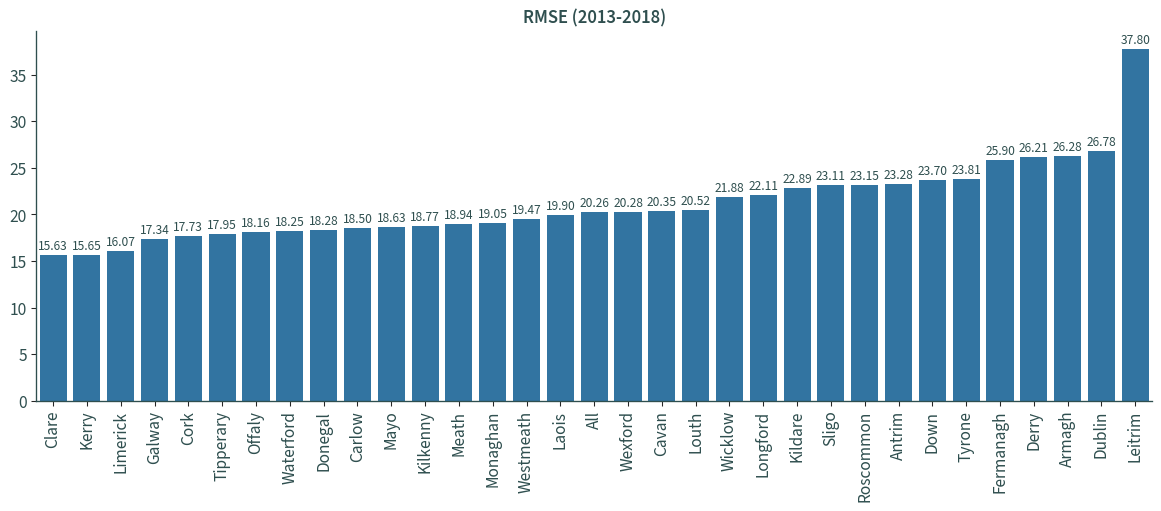

In [27]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=rmse_counties, x="index", y=0)
ax.bar_label(ax.containers[0], padding=2, fmt="{:.2f}")
plt.xticks(rotation=90)
plt.xlabel(None)
plt.ylabel(None)
plt.title("RMSE (2013-2018)")
sns.despine()
plt.show()

In [64]:
# drop counties with < 200 points
for c in ["Antrim", "Armagh", "Derry", "Down", "Fermanagh", "Tyrone", "Dublin", "Leitrim"]:
    data_pivot = data_pivot[data_pivot["county"] != c]

## Regression

In [65]:
data_pivot["month"] = data_pivot["time"].dt.month

In [66]:
conditions = [
    data_pivot["month"].isin([12, 1, 2]),
    data_pivot["month"].isin([3, 4, 5]),
    data_pivot["month"].isin([6, 7, 8]),
    data_pivot["month"].isin([9, 10, 11]),
]

In [67]:
choices = ["DJF", "MAM", "JJA", "SON"]

In [68]:
data_pivot["season"] = np.select(conditions, choices)

In [69]:
data_pivot.groupby("season").describe()[["Measured", "Simulated"]].transpose()

season                   DJF          JJA          MAM          SON
data                                                               
Measured  count  1253.000000  1884.000000  1845.000000  1804.000000
          mean      6.542953    60.717765    38.403366    35.127616
          min       0.000000     4.400000     0.000000     0.000000
          25%       3.760000    54.410000    14.500000    19.737500
          50%       5.550000    62.290000    38.190000    35.210000
          75%       8.150000    69.195000    57.890000    49.405000
          max      46.520000   124.310000   120.800000   106.820000
          std       4.653535    13.911997    24.875094    17.614601
Simulated count  1253.000000  1884.000000  1845.000000  1804.000000
          mean      0.745258    64.439311    17.792265    31.594535
          min       0.000000     0.064053     0.000000     0.320922
          25%       0.184382    51.090473     1.039724    11.476733
          50%       0.536290    67.109108     5.837760    29.004848
          75%       1.100322    80.210660    26.819036    49.031414
          max       5.265898   122.056033   110.948637   105.408235
          std       0.729700    23.580598    23.650905    22.585850

In [70]:
data_pivot_season = data_pivot[data_pivot["season"] != "DJF"]

In [71]:
data_pivot_all = data_pivot.copy()
data_pivot_all["season"] = "All"
data_pivot_all = pd.concat([data_pivot_all, data_pivot_season])

In [72]:
def get_regression(data, season):
    df = data[data["season"] == s]
    x = df["Measured"]
    y = df["Simulated"]

    model = sm.OLS(y, sm.add_constant(x))
    results = model.fit()

    print("\n" + "-" * 35, season, "-" * 35)
    print(results.summary())

    b, m = results.params
    r = results.rsquared
    return df, b, m, r


----------------------------------- All -----------------------------------
                            OLS Regression Results                            
Dep. Variable:              Simulated   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                 1.314e+04
Date:                Sun, 18 Aug 2024   Prob (F-statistic):               0.00
Time:                        02:07:25   Log-Likelihood:                -29303.
No. Observations:                6786   AIC:                         5.861e+04
Df Residuals:                    6784   BIC:                         5.862e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

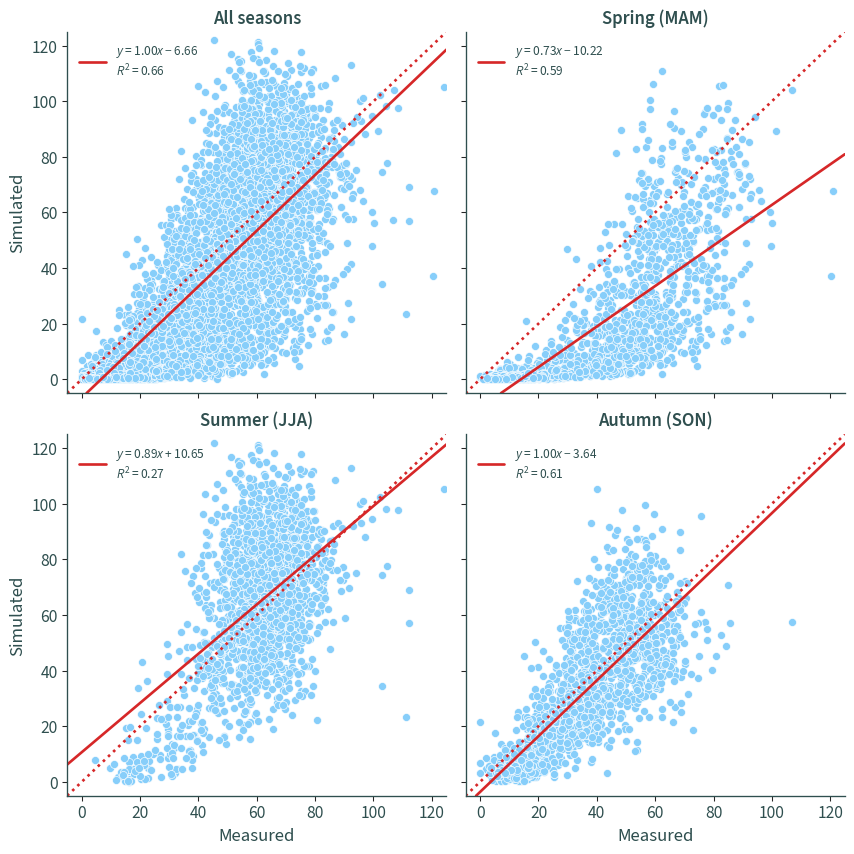

In [73]:
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(9, 9))
for s, t, axis in zip(["All", "MAM", "JJA", "SON"], ["All seasons", "Spring (MAM)", "Summer (JJA)", "Autumn (SON)"], ax.flat):
    df_plt, b, m, r = get_regression(data_pivot_all, s)
    axis.set_title(t)
    sns.scatterplot(data=df_plt, x="Measured", y="Simulated", color="lightskyblue", ax=axis)
    axis.axline((0, 0), slope=1, color="tab:red", linestyle="dotted", linewidth=2)
    axis.axline((0, b), slope=m, label=f"$y = {m:.2f}x {b:+.2f}$\n$R^2 = {r:.2f}$", color="tab:red", linewidth=2)
    axis.legend(frameon=False, facecolor=None)
    axis.set_xlim([-5, 125])
    axis.set_ylim([-5, 125])
sns.despine()
plt.tight_layout()
plt.show()

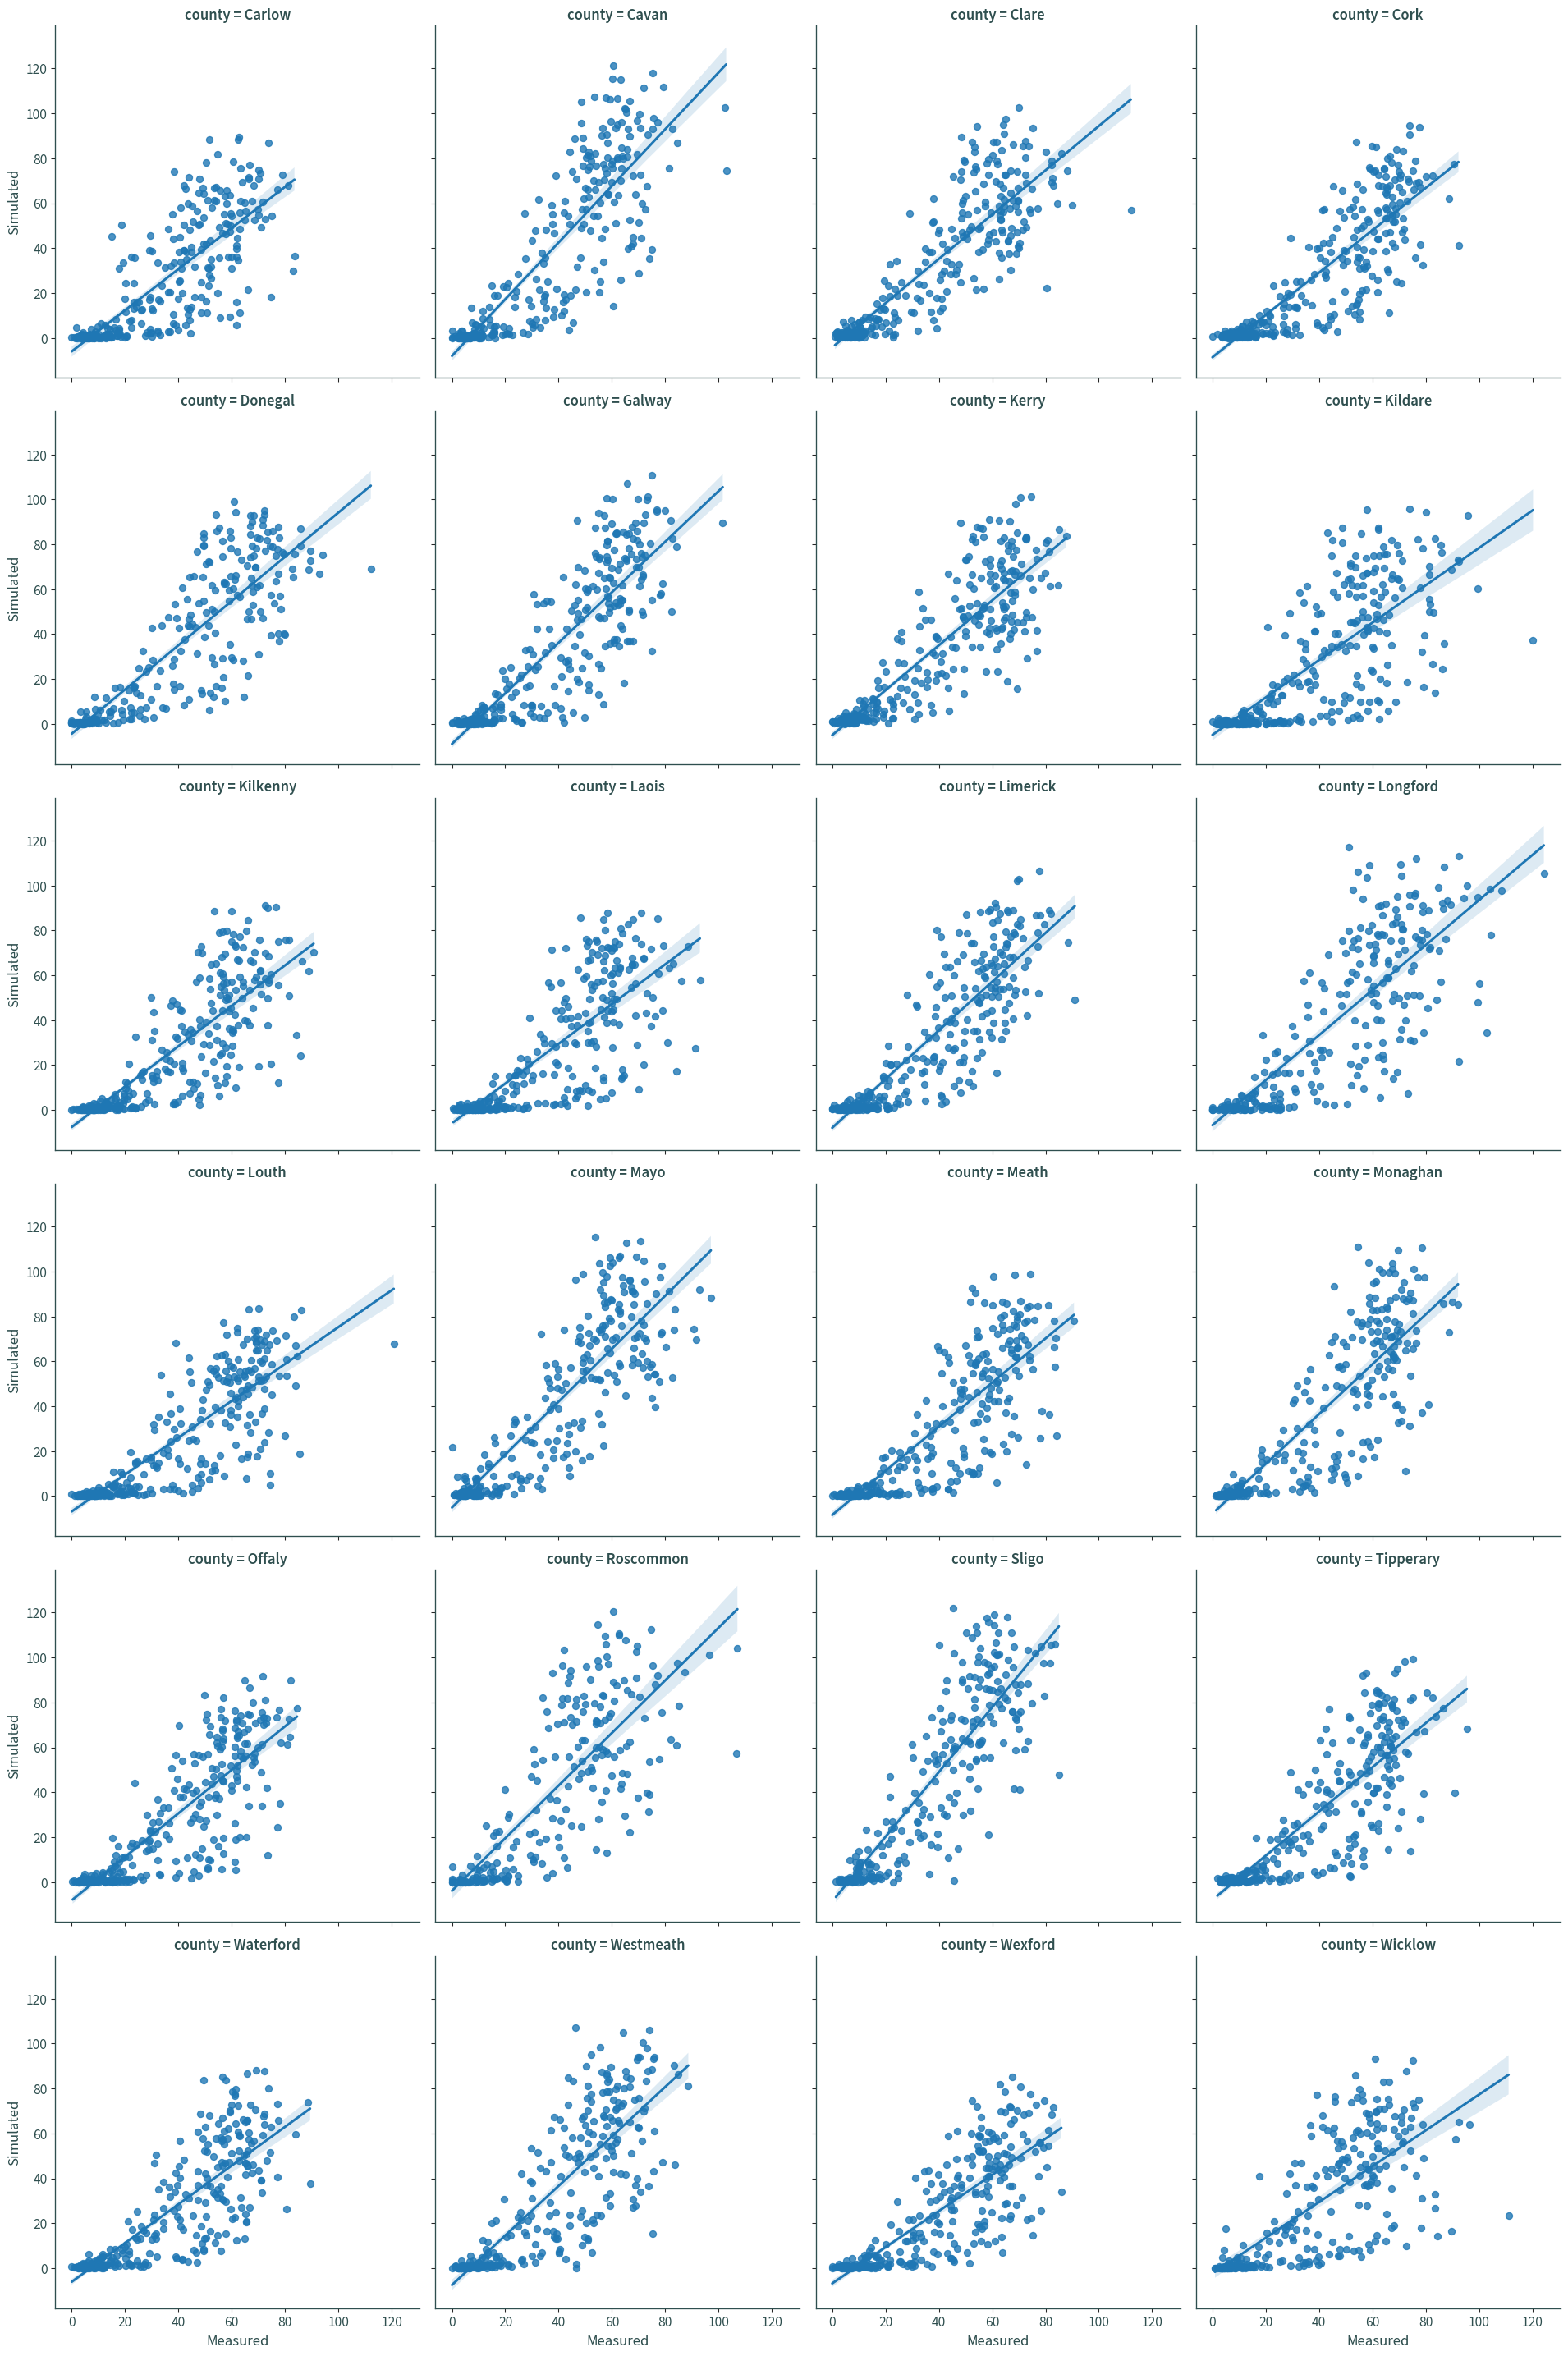

In [39]:
sns.lmplot(data=data_pivot, x="Measured", y="Simulated", col="county", col_wrap=4)
plt.show()